In [1]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import SamProcessor
import numpy as np
import zarr
from transformers import SamProcessor
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from cordmap.model import CORDNN
from cordmap.data import SUVIDataset, THEMATIC_MAP_COLORS, THEMATIC_MAP_CMAP

/home/mhughes/.conda/envs/cordmap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chosen_channels = np.array([2, 4, 5])  # channels = 171, 284, 304
device = "cuda" if torch.cuda.is_available() else "cpu"
cmap = THEMATIC_MAP_CMAP
model = CORDNN.load("/home/mhughes/full_model_50/")

# load images and masks
images = np.array(zarr.open("/d0/mhughes/thmap_suvi_valid_x.zarr"))
images = images[:, chosen_channels, :, :]
masks = np.array(zarr.open("/d0/mhughes/thmap_suvi_valid_y.zarr"))

# prepare dataset
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
valid_dataset = SUVIDataset(images, masks, processor=processor)
valid_dataloader = DataLoader(valid_dataset, 
                            batch_size=1, 
                            shuffle=False)

In [3]:
iterator = iter(valid_dataloader)
for i in range(83):
    batch = next(iterator)

In [4]:
result = model.predict_probabilities(batch)
thmap = model.predict(batch)
color_image = np.stack([result['coronal_hole'], result['prominence'], result['bright_region']], axis=-1)

In [5]:
color_image = np.stack([result['coronal_hole'], result['prominence'], result['bright_region']], axis=-1)

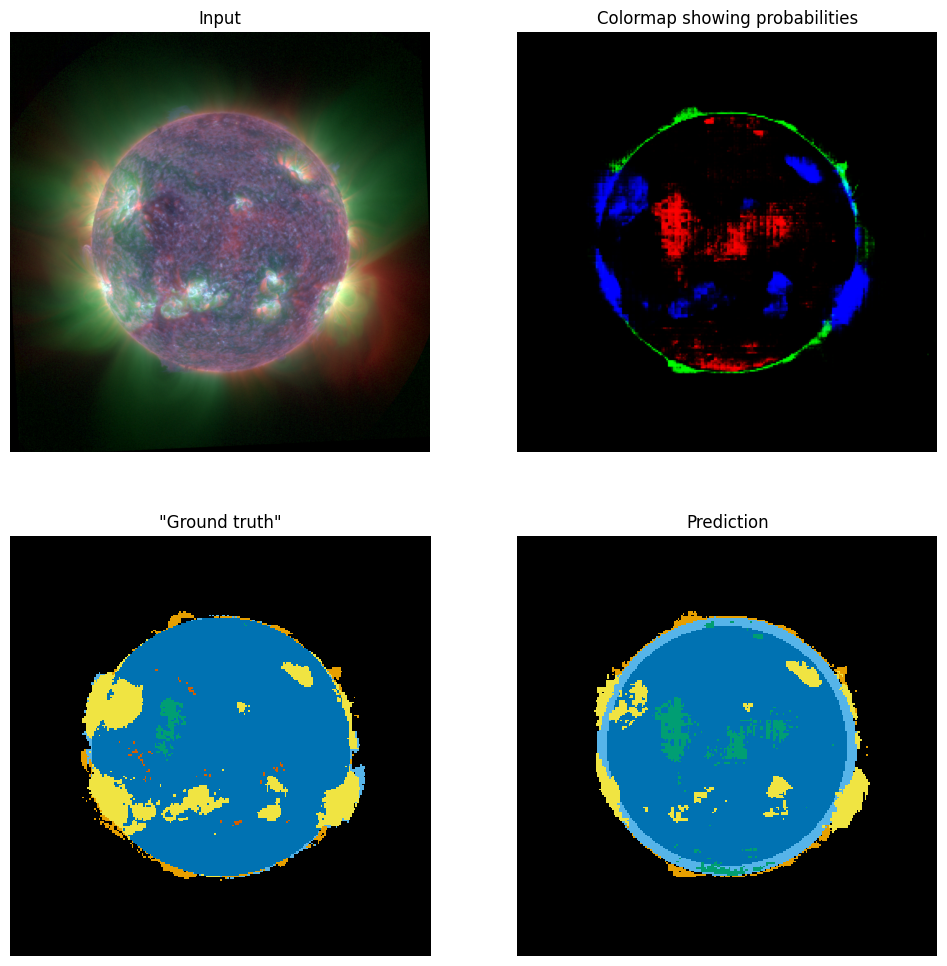

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axs[0, 0].imshow(np.moveaxis(np.array(batch['image'].squeeze()), 0, -1))
axs[0, 0].set_title("Input")

axs[1, 0].imshow(np.array(batch["ground_truth_mask"]).squeeze(), cmap=cmap,
                    vmin=-1,
                    vmax=len(THEMATIC_MAP_COLORS),
                    interpolation='none')
axs[1, 0].set_title('"Ground truth"')

axs[1, 1].imshow(thmap, cmap=cmap,
                    vmin=-1,
                    vmax=len(THEMATIC_MAP_COLORS),
                    interpolation='none')
axs[1, 1].set_title("Prediction")

axs[0, 1].imshow(color_image)
axs[0, 1].set_title("Colormap showing probabilities")

for ax in axs.flatten():
    ax.set_axis_off()

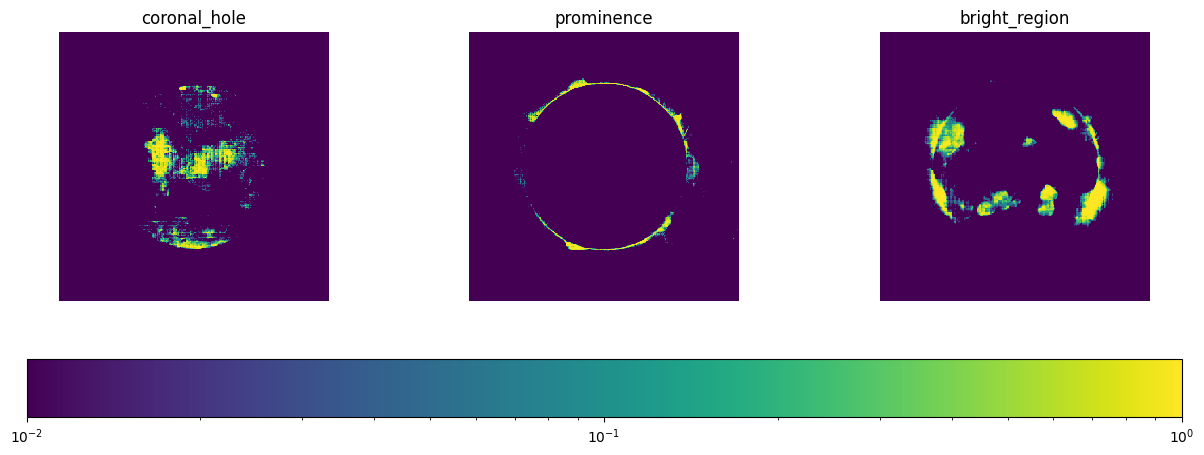

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for ax, theme in zip(axs, ['coronal_hole', 'prominence', 'bright_region']):
    im = ax.imshow(result[theme], norm=LogNorm(vmin=0.01, vmax=1), interpolation='none')
    ax.set_title(theme)
    ax.set_axis_off()
fig.colorbar(im, ax=axs, orientation='horizontal')

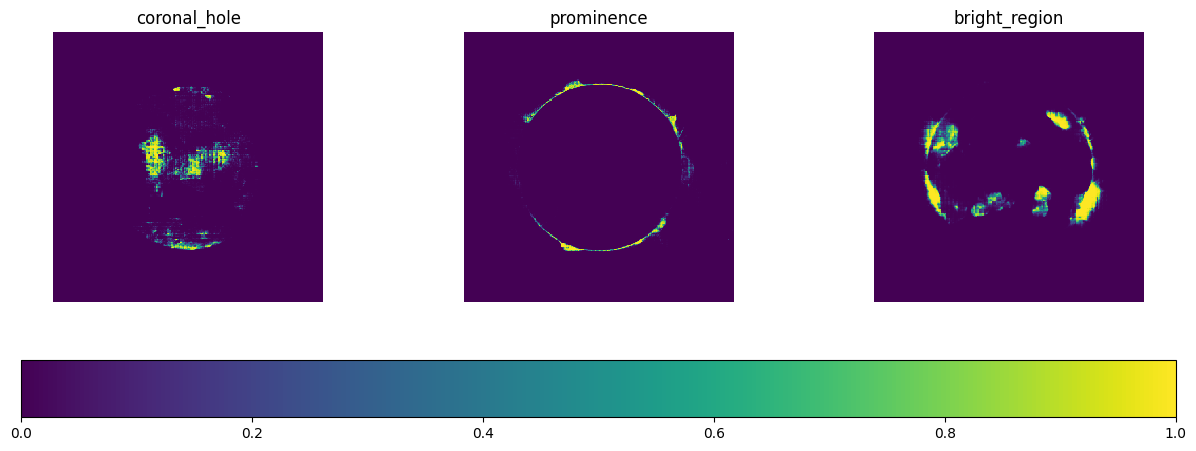

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for ax, theme in zip(axs, ['coronal_hole', 'prominence', 'bright_region']):
    im = ax.imshow(result[theme], vmin=0, vmax=1, interpolation='none')
    ax.set_title(theme)
    ax.set_axis_off()
fig.colorbar(im, ax=axs, orientation='horizontal')

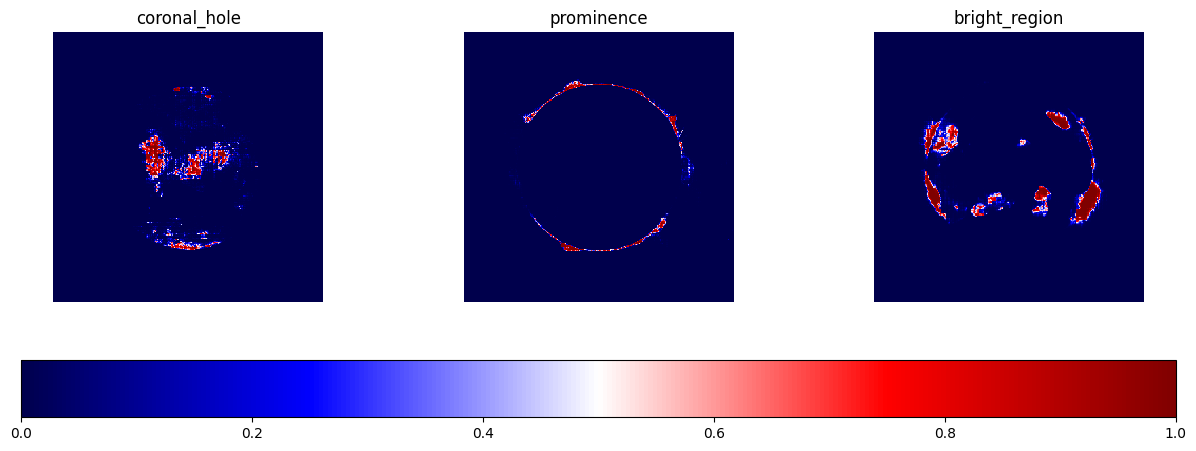

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for ax, theme in zip(axs, ['coronal_hole', 'prominence', 'bright_region']):
    im = ax.imshow(result[theme], vmin=0, vmax=1, cmap='seismic', interpolation='none')
    ax.set_title(theme)
    ax.set_axis_off()
fig.colorbar(im, ax=axs, orientation='horizontal')